# <u>Sea Level Rise Threat Index Tool </u>

#### Meg Manning -- *Duke University, Fall 2024*

► **Description:** this script can be used to identify an area in the coastal plain of North Carolina and assess it's risk to sea level rise. The overall threat index is calculated through combining the ranked exposure of inundation under 1ft, 2ft, and 3ft of sea level rise, flood prone areas, storm surge under category 1-5 hurricanes, soil erodibility, soil drainage, and areas of low slope for a given area of interest. Methods for forecasting sea level rise inundation were taken from the National Oceanic and Atmospheric detailed methology for sea level rise inundation (NOAA, 2017) and the overall threat index was modelled after the National Fish and Wildlife Service's Coastal Resilience and Siting Tool (CREST) (Dobson et al., 2019).

### 1. Digital Elevation Model from LiDAR 

*Download LiDAR point data and process into a 1m DEM.*

#### Since there is no API for a direct download of LiDAR point data, in order to process the entire tool, data must be downloaded following these steps *prior* to running the rest of this script. 

<u> Step 1: Download LiDAR Data </u> 

Click the link below to open the Digital Coast Topobathy LiDAR Web Interface: https://coast.noaa.gov/dataviewer/#/lidar/search/ 

<u>Step 1.1:</u> Zoom in to a scale of at least 1000ft, if not 500ft, and draw a box around the area of interest

<u>Step 1.2:</u> In the panel on the right, select the most recent *point* data that corresponds to the area of interest

<u>Step 1.3:</u> Click "Add to Cart" 

<u>Step 1.4:</u> In your cart, set the following parameters for your point data:
* Projection = UTM
* Zone = Zone 18 Range 078W-072W
* Horizontal Datum = NAD83
* Horizontal Units = Meters
* Vertical Datum = NADV88
* Vertical Units = Meters
* Output Product = Point
* Output Format = Points - LAS
* Data Classes = Ground 

<u>Step 1.5:</u> Click next, add email, review and submit

*It may take a few minutes for the data to process but you will recieve an email with the link to download the data. Once it downloads, extract the data to your machine and note the file path.*

<u> Step 2: Process into a 1m DEM</u> 

In [13]:
# Load Necessary Packages
import arcpy
import os

# Set the workspace 
#arcpy.env.workspace = "C:/path_to_lidar_data"
arcpy.env.workspace = "z:\MP\DATA\Lidar\nc2019_dunex_Job1104540"
arcpy.env.overwriteOutput = True

In [15]:
# Define LAS data and LAS dataset paths 
#**Can I make these user inputs?**
#las_folder = "C:/path_to_lidar_data"
#las_dataset = "C:/path_to_lidar_data/las_dataset.lasd"
las_folder = "z://MP//DATA//Lidar//nc2019_dunex_Job1104540"
las_dataset = "z://MP//DATA//Lidar//nc2019_dunex_Job1104540//nc2019_dunex_Job1104540.las"

# Create a LAS Dataset using Create LAS Dataset Tool 
arcpy.management.CreateLasDataset(las_folder, las_dataset)

<Result 'z:\\\\MP\\\\DATA\\\\Lidar\\\\nc2019_dunex_Job1104540\\nc2019_dunex_Job1104540.lasd'>

In [18]:
# Define output raster (DEM) path 
ground_DEM = "z:/MP/DATA/Lidar/nc2019_dunex_Job1104540/nc2019_dunex_Job1104540.las/DEM_1m.tif"

# Create 1m DEM using LAS Dataset to Raster tool 
ground_DEM = arcpy.conversion.LasDatasetToRaster(las_dataset, ground_DEM, 
                                    'ELEVATION', 
                                    'BINNING AVERAGE LINEAR', 
                                    'FLOAT', 
                                    'CELLSIZE', 1, 1)


ExecuteError: ERROR 000210: Cannot create output z:\MP\DATA\Lidar\nc2019_dunex_Job1104540\nc2019_dunex_Job1104540.las\DEM_1m.tif
Failed to execute (LasDatasetToRaster).


### 2. Tidal Variability Surface Using Vertical Datum Tool

*Use DEM created above to create a tidal surface raster that shows the tidal fluctuations at the area of interest. Once this is created then sea level rise inundation can be calculated.*

https://vdatum.noaa.gov/docs/services.html#step120

In [ ]:
# Create Points from DEM to input into VDatum tool to get conversion from MHHW into NAVD88

# Raster to Point - set local variables 
in_DEM = ground_DEM
out_point_features = 'DEM_points.shp'
field = "VALUE"

# Run the tool
# arcpy.conversion.RasterToPoint(in_DEM, out_point_features, field)

#IS THERE AN EASIER WAY TO DO THIS?

### 3. Inundation Extent under 1-3ft SLR

*Use both the DEM in step 1 and the tidal variabliity surface in step 2 to model the desired amount of sea level rise at 1 meter resolution on top of the area of interest. For detailed methods see Detailed Method for Mapping Sea Level Rise Inundation (NOAA, 2017).*

<u> Iterate through sea level rise of 1ft (0.3048m), 2ft (0.6096m), and 3ft (0.9144m) for area of interest using tidal variability surface.</u>

In [5]:
# Load necessary packages 
import arcpy
from arcpy.ia import *
from arcpy.sa import *
import os

# Allow outputs to be overwritten
arcpy.env.overwriteOutput = True

# Check out any necessary licenses.
arcpy.CheckOutExtension("3D")
arcpy.CheckOutExtension("spatial")
arcpy.CheckOutExtension("ImageAnalyst")

# Set local variables -- INPUTS MAP TO GROUND DEM (TIDAL VARIABILITY), OUTPUT DIRECTORY 
ground_DEM = "C:/Users/mgm79/Downloads/nc2019_dunex_Job1099351/DEM_1m.tif" #** this has to change to tidal surface raster
output_directory = "../Scratch/"

# Create function to iterate through SLR of 1-3ft
SLR_values = [0.3048, 0.6096, 0.9144]

# Create a function to process inundation for all SLR values 
def process_inundation(SLR_value, ground_DEM, output_directory) :
    # Add SLR amount to surface 
    surface_raster = Raster(ground_DEM) + SLR_value
    surface_raster_output = os.path.join(output_directory, f'surface_{SLR_value}m.tif')
    surface_raster.save(surface_raster_output)

    # Load ground DEM as Raster 
    input_con = Raster(ground_DEM)

    # Raster Calculator - create single value DEM to show inundation extent
    single = Con(input_con <= surface_raster, 1)
    single_output = os.path.join(output_directory, f'single_{SLR_value}m.tif')
    single.save(single_output)

    # Region Group - Evaluate connectivity of extent raster using region group
    clumped = arcpy.sa.RegionGroup(single, "EIGHT", "WITHIN", "NO_LINK", None)
    clumped_output = os.path.join(output_directory, f'clumped_{SLR_value}m.tif')
    clumped.save(clumped_output)

    # Extract by Attributes - Extract connected inundation surface to be used as a mask for the original depth grid
    lowlying = arcpy.sa.ExtractByAttributes(clumped, "Count < 1000000")
    lowlying_output = os.path.join(output_directory, f'lowlying_{SLR_value}m.tif')
    lowlying.save(lowlying_output)

    # Raster Calculator (2) - Subtract DEM values from water surface to derive initial inundatino depth grid
    depth =  Con(input_con <= surface_raster, surface_raster - input_con) 
    depth_output = os.path.join(output_directory, f'depth_{SLR_value}m.tif')
    depth.save(depth_output)
    
    # Extract by Attributes (2) - Derive low-lying areas 
    connect = arcpy.sa.ExtractByAttributes(clumped, "Count > 1000000")
    connect_output = os.path.join(output_directory, f'connect_{SLR_value}m.tif')
    connect.save(connect_output)

    # Extract by Mask - Create depth grid for connected areas
    con_depth = arcpy.sa.ExtractByMask(depth, connect)
    con_depth_output = os.path.join(output_directory, f'con_depth_{SLR_value}m.tif')
    con_depth.save(con_depth_output)

    print(f"Processed SLR = {SLR_value}m")

# Iterate through each SLR value (1ft, 2ft, 3ft)
for SLR_value in SLR_values:
    process_inundation(SLR_value, ground_DEM, output_directory)


RuntimeError: ERROR 000732: Input Raster: Dataset C:/Users/mgm79/Downloads/nc2019_dunex_Job1099351/DEM_1m.tif does not exist or is not supported

### 4. Scrape & Process Threat Index Layers 

*Prepare each dataset following the methods detailed in Dobson et al. (2019) to create an index of overall threat from sea level rise.*

### Sea Level Rise Ranking

Rank the inundation from sea level rise of 1-3ft.

In [10]:
# Reclassify SLR inundation layers 
SLR_1ft = Raster("../Scratch/con_depth_0.3048m.tif")
SLR_2ft = Raster("../Scratch/con_depth_0.6096m.tif")
SLR_3ft = Raster("../Scratch/con_depth_0.9144m.tif")


In [ ]:

# Set local variables 
from arcpy.sa import RemapRange
remap = RemapRange([[0,0.25, 5],
                   [0.25, 0.50, 4],
                   [0.50,0.75, 3], 
                   [0.75,1, 2],
                   [1,2, 1],
                   [2,100, 0]])

# Reclassify Slope Raster 
reclassified_slope = arcpy.sa.Reclassify(outSlope, "VALUE", remap, "NODATA")

#Save the new file 
reclassified_slope.save("../Scratch/slope_ranked.tif")


### Flood Prone Areas 

Extract the National Flood Hazard Layer (NFHL) from FEMA Flood Prone Areas database (FEMA, 2022).

In [21]:
# Import necessary packages 
import pandas as pd

from arcgis import GIS
from arcgis.geocoding import geocode
from arcgis.mapping import WebMap, MapServiceLayer, MapFeatureLayer
from arcgis.features import FeatureLayer, GeoAccessor
from arcgis.geometry import filters

gis = GIS('home')

In [22]:
#Get the web mapping application item FEMA provides
fema_web_map_app = gis.content.get('8b0adb51996444d4879338b5529aa9cd')
fema_web_map_app.type

'Web Mapping Application'

In [23]:
#Get the data associated with the item
fema_web_map_app_data = fema_web_map_app.get_data()

#From the dictionary, extract the map's item ID
fema_web_map_app_ID = fema_web_map_app_data['map']['itemId']

#Find the item associated with that item 
fema_web_map_item = gis.content.get(fema_web_map_app_ID)
fema_web_map_item.type

'Web Map'

In [24]:
#Create a web map from the web map item
fema_web_map = WebMap(fema_web_map_item)

#Extract its layers
fema_web_map_layers = fema_web_map.layers

#Show the layer titles
[layer['title'] for layer in fema_web_map_layers]

['Effective FIRM Panels',
 'NFHL',
 'Coastal Barrier Resources System Area (US FWS)']

In [25]:
#Get the URL for the MapServiceLayer
the_layer = fema_web_map.layers[1]
the_layer_url = the_layer.url
print(the_layer_url)

# Grab the Flood Hazard Zones
the_service_url = the_layer_url + '/20'

https://hazards.fema.gov/arcgis/rest/services/FIRMette/NFHLREST_FIRMette/MapServer


In [26]:
#Create a MapServiceLayer object from the url
fema_ms_layer = MapServiceLayer(fema_web_map_layers[1]['url'])
fema_layers = fema_ms_layer.properties['layers']
len(fema_layers)

32

In [27]:
#Fetch the layer
nhfl_layer = FeatureLayer(the_service_url)
nhfl_layer

<FeatureLayer url:"https://hazards.fema.gov/arcgis/rest/services/FIRMette/NFHLREST_FIRMette/MapServer/20">

In [28]:
# CAN I MAKE THIS A USER INPUT FOR THE COUNTY THE AREA OF INTEREST IS LOCATED IN?

#Create a spatial filter for Hyde County
county_lyr = gis.content.get('14c5450526a8430298b2fa74da12c2f4').layers[0]

#Make this query a user input for county - drop down for field name 
county_sdf = county_lyr.query("STATE_NAME = 'North Carolina' AND NAME = 'Hyde County'").sdf
county_geom = county_sdf.iloc[0,-1]
county_filter = filters.intersects(county_geom)

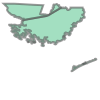

In [17]:
county_geom

In [29]:
#con_depth.extent
county_filter = filters.intersects(con_depth_ .extent)

NameError: name 'con_depth_' is not defined

In [32]:
#Spatially query the nhfl feature layers
nhfl_fset = nhfl_layer.query(geometry_filter=county_filter)
nhfl_fset

<FeatureSet> 15 features

In [33]:
#Convert to sdf
nhfl_sdf = nhfl_fset.sdf
nhfl_sdf.spatial.to_featureclass('../Scratch/Hyde_NHFL.shp')

'z:\\MP\\Scratch\\Hyde_NHFL.shp'

##### Add ranking to flood layer 

In [ ]:
# Reclassify shapefile 


### Storm Surge

Extract data for storm surge extents under a category 1-5 hurricane for the area of interest. This data is from the National Hurricane Center (Zachry, B. C. et al. 2015).

In [ ]:
import arcpy
from arcgis.gis import GIS
from arcgis.raster import Raster
from arcgis.raster import ImageryLayer
from arcpy.sa import RemapRange, Reclassify
import os

# Define Ranking Scheme 
remap_values = [
    RemapRange([[0, 100, 5]]),  # Category 1 - Rank 5
    RemapRange([[0, 100, 4]]),  # Category 2 - Rank 4
    RemapRange([[0, 100, 3]]),  # Category 3 - Rank 3
    RemapRange([[0, 100, 2]]),  # Category 4 - Rank 2
    RemapRange([[0, 100, 1]])   # Category 5 - Rank 1
]

# Ensure the output directory exists
output_directory = r"C:\path\to\output"  # Change this to your desired output path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load storm surge rasters for each category via ArcGIS Online
surge_rasters_urls = [
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category1_v3/MapServer',
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category2_v3/MapServer',
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category3_v3/MapServer',
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category4_v3/MapServer',
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category5_v3/MapServer'
]

# Initialize ArcGIS Online connection (or use a local GIS connection)
gis = GIS("home")  # Replace with your GIS connection if needed

# Function to fetch and save raster data from ImageServer
def fetch_raster_from_imagery_layer(url, extent, output_path):
    imagery_layer = ImageryLayer(url)

    # Query the imagery layer using the extent (define the area you are interested in)
    raster = imagery_layer.query(extent=extent, format='TIFF')

    # Save the raster to the local machine
    raster.save(output_path)
    return raster

# Function to reclassify all the storm surge rasters
def reclassify_stormsurge(surge_rasters_urls, output_directory):
    reclassified_rasters = []

    
    # Iterate through each storm surge raster and reclassify based on ranking scheme
    for idx, surge_url in enumerate(surge_rasters_urls):
        try:
            print(f"Loading raster from: {surge_url}")

            # Fetch raster using imagery layer query
            local_raster_path = os.path.join(output_directory, f'cat{idx+1}_surge.tif')
            surge_raster = fetch_raster_from_imagery_layer(surge_url, extent, local_raster_path)
            print(f"Loaded and saved raster: {local_raster_path}")

            # Reclassify based on remap range 
            reclass_raster = Reclassify(local_raster_path, "VALUE", remap_values[idx], "NODATA")

            # Save reclassified raster
            reclass_output = os.path.join(output_directory, f'cat{idx+1}_reclass.tif')
            reclass_raster.save(reclass_output)
            print(f"Reclassified and saved to: {reclass_output}")

            # Add to list of reclassified rasters
            reclassified_rasters.append(reclass_raster)

        except Exception as e:
            print(f"Error processing Raster {idx + 1}: {e}")
            continue
    
    return reclassified_rasters

# Process the storm surge rasters
surge_ranked = reclassify_stormsurge(surge_rasters_urls, output_directory)

Loading raster from: https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category1_v3/MapServer
Error processing Raster 1: ImageryLayer.query() got an unexpected keyword argument 'extent'
Loading raster from: https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category2_v3/MapServer
Error processing Raster 2: ImageryLayer.query() got an unexpected keyword argument 'extent'
Loading raster from: https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category3_v3/MapServer
Error processing Raster 3: ImageryLayer.query() got an unexpected keyword argument 'extent'
Loading raster from: https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category4_v3/MapServer
Error processing Raster 4: ImageryLayer.query() got an unexpected keyword argument 'extent'
Loading raster from: https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/service

In [ ]:
# Load Necessary Packages
import arcpy
from arcgis.raster import Raster
from arcpy.sa import RemapRange, Reclassify

# Load local variables 
geom_projected = county_geom.project_as({"wkid": 102100})

def reclassify_stormsurge(surge_rasters, output_directory):
    remap_values = [
        RemapRange([[0, 100, 5]]) # Cat. 1 - Rank 5
        RemapRange([[0,100, 4]]) # Cat. 2 - Rank 4
        RemapRange([[0,100, 3]]) # Cat. 3 - Rank 3
        RemapRange([[0,100, 2]]) # Cat. 4 - Rank 2
        RemapRange([[0,100, 1]]) # Cat 5. - Rank 1
    ]

    reclassified_rasters = []

for idx, surge_raster in enumerate(surge_rasters):
    # Reclassify each raster based on ranking scheme 
    reclass_raster = 


# Category 1
surge1_raster = Raster(
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category1_v3/MapServer?f=html&cacheKey=8c1eda5e290c30bd'
)
surge1_raster.extent = geom_projected.envelope

# Category 2
surge2_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category2_v3/MapServer?f=html&cacheKey=bc29bd820e1e09aa'
)
surge2_raster.extent = geom_projected.envelope

# Category 3
surge3_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category3_v3/MapServer?f=html&cacheKey=990f926f2812a1e0'
)
surge3_raster.extent = geom_projected.envelope

# Category 4
surge4_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category4_v3/MapServer?f=html&cacheKey=ba281138bc28168f'
)
surge4_raster.extent = geom_projected.envelope

# Category 5
surge5_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category5_v3/MapServer?f=html&cacheKey=a407a7ec582a37b0'
)
surge5_raster.extent = geom_projected.envelope

#Create remap values for Reclassification of each layer 
surge5 = RemapRange([[0,100, 1]])
surge4 = RemapRange([[0,100, 2]])
surge3 = RemapRange([[0,100, 3]])
surge2 = RemapRange([[0,100, 4]])
surge1 = RemapRange([[0, 100, 5]])

Surge_values = [surge1, surge2, surge3, surge4, surge5]

#Save the new file 
surge1_raster = surge1_raster.export_image(save_folder=output_directory, save_file="{Surge_Value}_raster.tif")

# Reclassify Surge 1 Raster 
surge1_reclass = arcpy.sa.Reclassify(surge1_raster, "VALUE", surge1, "NODATA")

In [30]:
# Load Necessary Packages
from arcgis.raster import Raster

# Load local variables 
geom_projected = county_geom.project_as({"wkid": 102100})


In [33]:
# Get the layers for storm surge under cat. 1-5 storms 
surge1_raster = Raster(
    'https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category1_v3/MapServer?f=html&cacheKey=8c1eda5e290c30bd'
)
surge1_raster.extent = geom_projected.envelope
output_raster = surge1_raster.export_image(save_folder="../Scratch", save_file="surge1_raster.tif")
#surge1_raster.save('../Scratch/surge1_raster')


In [37]:
surge1_arcpy = arcpy.Raster(output_raster)
surge1 = RemapRange([[0, 100, 5]])

In [38]:
surge1_reclass = arcpy.sa.Reclassify(surge1_arcpy, "VALUE", surge1, "NODATA")

ExecuteError: ERROR 000875: Output raster: z:\MP\DATA\Lidar
c2019_dunex_Job1104540\Reclass_surge1_1.tif's workspace is an invalid output workspace.
ERROR 000581: Invalid parameters.
Failed to execute (Reclassify).


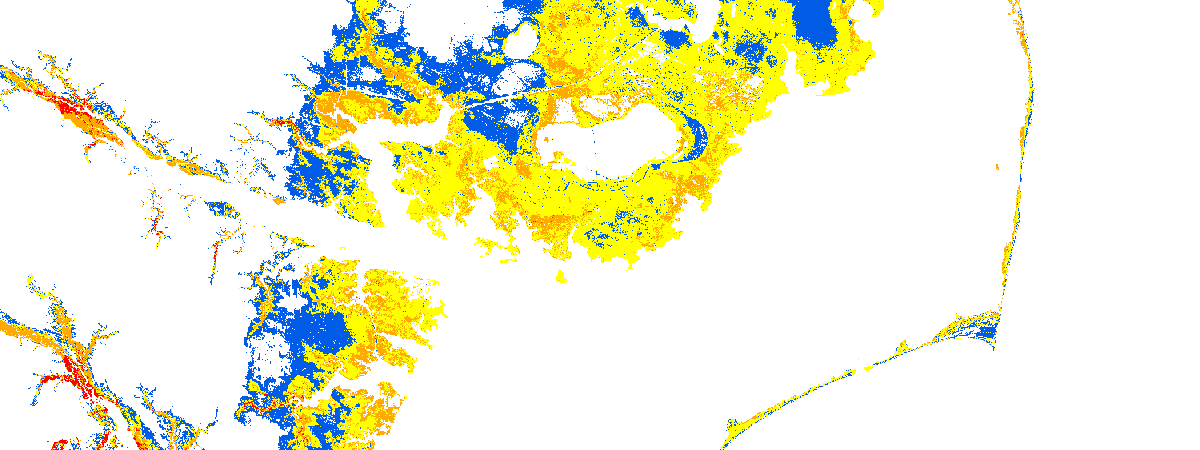

In [ ]:
# Get the layers for storm surge under cat. 1-5 storms 
surge2_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category2_v3/MapServer?f=html&cacheKey=bc29bd820e1e09aa'
)
surge2_raster.extent = geom_projected.envelope
surge2_raster  

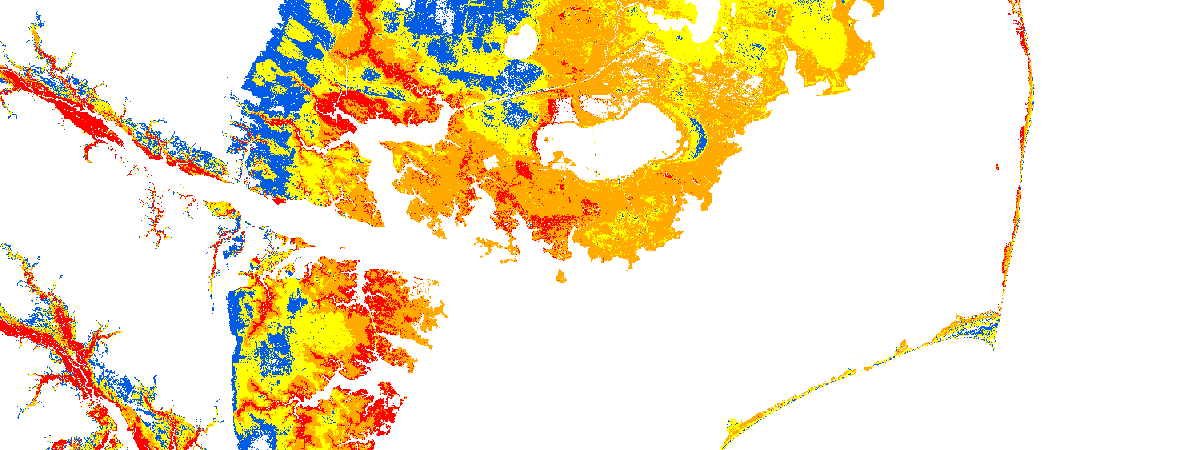

In [42]:
# Get the layers for storm surge under cat. 1-5 storms 
surge3_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category3_v3/MapServer?f=html&cacheKey=990f926f2812a1e0'
)
surge3_raster.extent = geom_projected.envelope
surge3_raster  

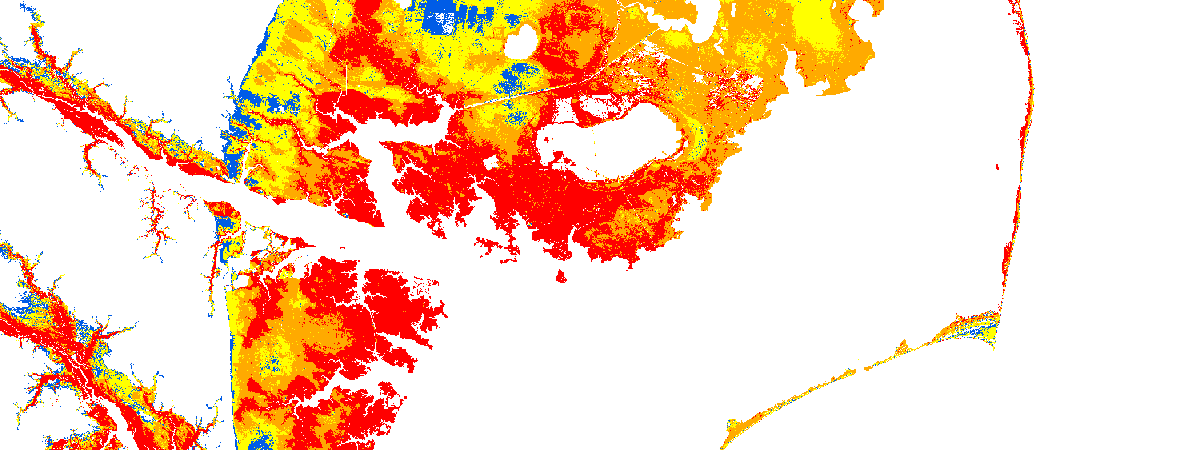

In [43]:
# Get the layers for storm surge under cat. 1-5 storms 
surge4_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category4_v3/MapServer?f=html&cacheKey=ba281138bc28168f'
)
surge4_raster.extent = geom_projected.envelope
surge4_raster  

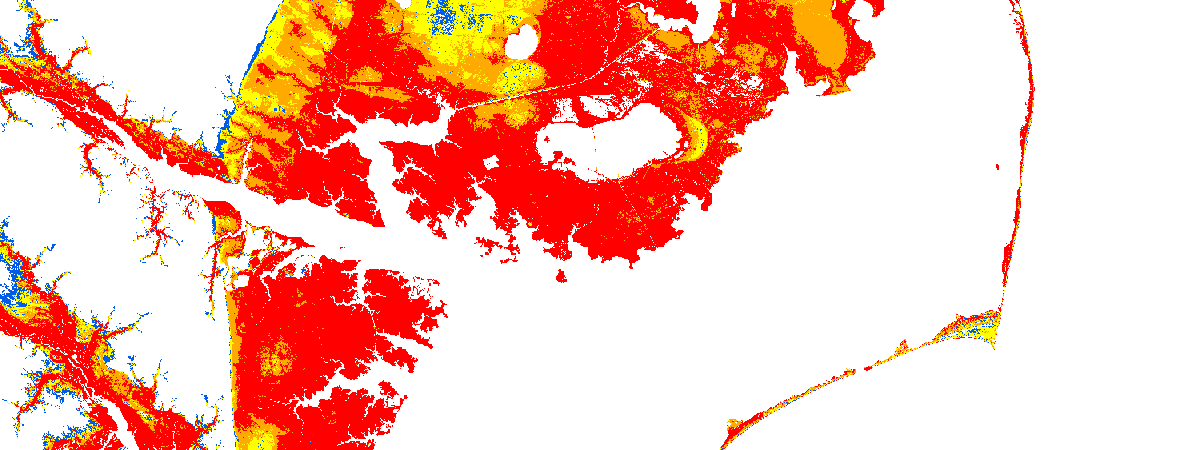

In [44]:
# Get the layers for storm surge under cat. 1-5 storms 
surge5_raster = Raster('https://tiles.arcgis.com/tiles/C8EMgrsFcRFL6LrL/arcgis/rest/services/Storm_Surge_HazardMaps_Category5_v3/MapServer?f=html&cacheKey=a407a7ec582a37b0'
)
surge5_raster.extent = geom_projected.envelope
surge5_raster  

In [ ]:
# Reclassify and rank storm surge inputs 
from arcpy.sa import RemapRange
from arcpy.sa import *
#remap_surge5 = RemapRange([[0,100, 1]])
#remap_surge4 = RemapRange([[0,100, 2]])
#remap_surge3 = RemapRange([[0,100, 3]])
#remap_surge2 = RemapRange([[0,100, 4]])
remap_surge1 = RemapRange([[0, 100, 5]])

#Save the new file 
surge1_raster = surge1_raster.export_image(save_folder="..\\Scratch", save_file="surge1_raster.tif")
#surge1_reclass.save("../Scratch/surge1_ranked.tif")

# Reclassify Surge 1 Raster 
surge1_reclass = arcpy.sa.Reclassify(surge1_raster, "VALUE", remap_surge1, "NODATA")

### Areas of Low Slope

Calculate the slope of the Digital Elevation Model and reclassify the raster to create a rank for areas of low slope. 

In [38]:
# Set local variables 
in_raster = input_con
output_measurement = "PERCENT_RISE"

In [39]:
# Execute Slope
outSlope = arcpy.sa.Slope(in_raster, output_measurement)
outSlope.save("../Scratch/slope.tif") #will probably have to change this with input?

In [41]:
# Set local variables 
from arcpy.sa import RemapRange
remap = RemapRange([[0,0.25, 5],
                   [0.25, 0.50, 4],
                   [0.50,0.75, 3], 
                   [0.75,1, 2],
                   [1,2, 1],
                   [2,100, 0]])

# Reclassify Slope Raster 
reclassified_slope = arcpy.sa.Reclassify(outSlope, "VALUE", remap, "NODATA")

#Save the new file 
reclassified_slope.save("../Scratch/slope_ranked.tif")

### Soil Erodibility & Drainage

Add the erodibility factor (K Factor) and the drainage ranking for the soils located in area of interest.

### 5. Calculate Final Threat Index Layer 

*Combine each ranked and processed data layer to produce a final layer that shows the overall threat to SLR for area of interest. To complete the Threat Index, an ordinal combination method was used where cell values were added together and then classified into 10 groups to create a raster that can be used for the Exposure Index calculation. For detailed methodology refer to the Regional Coastal Resilience Assessment from the National Fish and Wildlife Foundation (2015).*

In [ ]:
# Load all necessary layers from previous steps 

# Flood Prone Areas Ranked
#flood_ranked = 

# SLR Ranked
#SLR_ranked = 

# Storm Surge Ranked
#surge_ranked = 

# Slope Ranked
#slope_ranked = 

# Erodibility Ranked
#erodibility_ranked = 

# Drainage Ranked 
#drainage_ranked = 

# Combine all ranked layers for final index 
#combined_threat = flood_ranked + SLR_ranked + surge_ranked + erodibility_ranked + drainage_ranked 
#final_output = os.path.join(output_directory, f'Threat_Index_FinalRank.tif')
#final_ranked = arcpy.ddd.Reclassify(in_raster=combined_threat, 
 #                                   reclass_field="VALUE", 
 #                                   remap="0 1 1;2 4 2;5 6 3;7 8 4;9 10 5;11 12 6;13 14 7;15 17 8;18 23 9;24 32 10", 
 #                                   out_raster=final_output, 
 #                                   missing_values="DATA")


In [ ]:
# Look at final layer 
#Raster(final_ranked)

#### References 

#### Dobson, G., Johnson, I., Rhodes, K., Hutchins, M., & Chesnutt, M. (2019). Regional coastal resilience assessment: Methodology. National Fish and Wildlife Foundation. Retrieved November 21, 2024, from https://www.nfwf.org/sites/default/files/coastalresilience/Documents/regional-coastal-resilience-assessment.pdf

#### Federal Emergency Management Agency (FEMA). (2022). National Flood Hazard Layer (NFHL). FEMA. Retrieved November 24, 2024, from https://hazards.fema.gov/femaportal/wps/portal/NFHLWMS

#### National Fish and Wildlife Foundation. (2015). Regional coastal resilience assessment. National Fish and Wildlife Foundation. https://www.nfwf.org/sites/default/files/coastalresilience/Documents/regional-coastal-resilience-assessment.pdf

#### National Oceanic and Atmospheric Administration. (2017, January). Sea level rise inundation methods: Technical documentation. NOAA Office for Coastal Management. Retrieved November 21, 2024, from https://coast.noaa.gov/data/digitalcoast/pdf/slr-inundation-methods.

#### Zachry, B. C., W. J. Booth, J. R. Rhome, and T. M. Sharon, 2015: A National View of Storm Surge Risk and Inundation. Weather, Climate, and Society, 7(2), 109–117. DOI: http://dx.doi.org/10.1175/WCAS–D–14–00049.1